# Intro

Here I use data from the City to Chicago to analyze and visualize features of its pothole response team.

In [1]:
import pandas as pd

data = pd.read_csv('/Users/trevornyman/downloads/Data Set for Case Study.csv')

/Users/trevornyman/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Point 1

CDOT had its highest number of requests in March of 2014: 25,419 requests.

In [ ]:
from collections import Counter

#Request counts descending by month, year
Counter((x[:2]+x[-1:]) for x in data['CREATION DATE']).most_common()


## Point 2

As of December 31, 2016, there are 3,155 pothole reports still open.

In [ ]:
len(data[data['STATUS'].str.contains("[O,o]pen")])

## Point 3

In 2016, it took an average of 20.4 days to resolve a pothole request.

In [3]:
import numpy as np

#Change Creation Date and Completion Date columns to datetime objects
data['CREATION DATE'] = pd.to_datetime(data['CREATION DATE'])
data['COMPLETION DATE'] = pd.to_datetime(data['COMPLETION DATE'])

#Create new column, Time to Resolution, by subtracting CREATION DATE from COMPLETION DATE
data['TIME TO RESOLUTION'] = data['COMPLETION DATE'] - data['CREATION DATE']

#Boolean mask
mask = (data['CREATION DATE'] >= '2016-1-1') & (data['CREATION DATE'] <= '2016-12-31')

#assign data subsetting for mask to variable
data_2016 = data.loc[mask]


#trip off rows which aren't completed and so don't have a TIME TO RESOLUTION value
data_2016 = data_2016[data_2016['STATUS'] == 'Completed']

times= []
for i in data_2016['TIME TO RESOLUTION']:
    times.append(i.days)
print (sum(times)/len(times))

20.366967776729137


## Point 4
I'll define variability in time taken to resolve pothole reports as the difference between the maximum time of resolution and the minimum time of resolution, representing the range of service times experienced in a particular community area.  The community area of Austin has the largest amount of variability in service at 688 days.

In [ ]:
for area in data['Community Area'].unique():
    DF_area = data[data['Community Area']==area]
    DF_area = DF_area[DF_area['STATUS'] == 'Completed']
    print ("Area:", area, "- Variability in Service Time:", DF_area['TIME TO RESOLUTION'].max() - DF_area['TIME TO RESOLUTION'].min())




### Factors affecting number of reports

One natural thought is that there will be more reports of potholes during colder months; since potholes occur when water seeps into the pavement and freezes making it brittle, we'd suspect pothole occurence to increase as temperatures head below freezing.  Taking the monthly counts from preliminary analysis, we can plot the respective totals and confirm our natural thought: we definitely see an uptick in December when monthly average temperatures are below freezing, increasing through February and then decreasing considerably as it gets warmer.

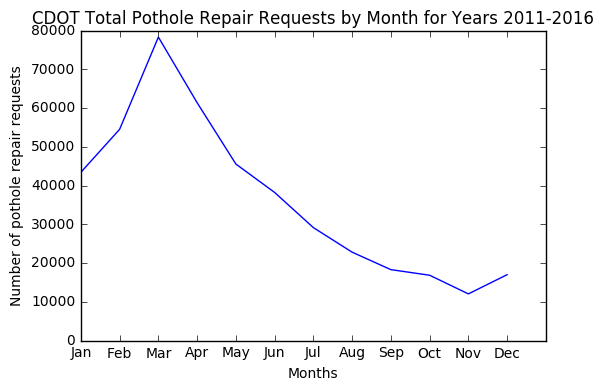

In [4]:
import matplotlib.pyplot as plt

Counts_by_month = [43407,54502, 78291, 61364, 45540,38209,29131,22793,18286, 16843,12029,16987]
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.plot(Counts_by_month)
plt.xticks(range(len(Counts_by_month)),Months)
plt.xlabel('Months')
plt.ylabel('Number of pothole repair requests')
plt.title('CDOT Total Pothole Repair Requests by Month for Years 2011-2016')
plt.ylim(ymin=0)
plt.show()


We can also take a look at how the number of repair requests varies by year.

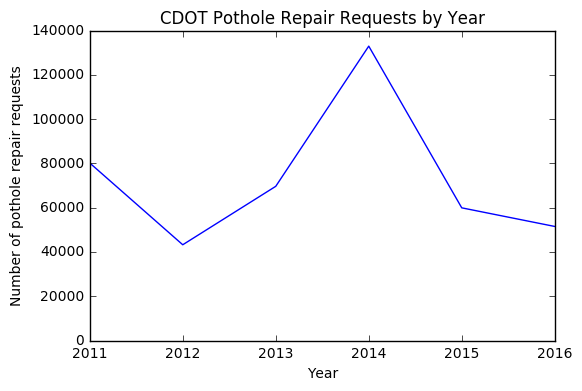

In [13]:
mask_2011 = (data['CREATION DATE'] >= '2011-1-1') & (data['CREATION DATE'] <= '2011-12-31')
mask_2012 = (data['CREATION DATE'] >= '2012-1-1') & (data['CREATION DATE'] <= '2012-12-31')
mask_2013 = (data['CREATION DATE'] >= '2013-1-1') & (data['CREATION DATE'] <= '2013-12-31')
mask_2014 = (data['CREATION DATE'] >= '2014-1-1') & (data['CREATION DATE'] <= '2014-12-31')
mask_2015 = (data['CREATION DATE'] >= '2015-1-1') & (data['CREATION DATE'] <= '2015-12-31')
mask_2016 = (data['CREATION DATE'] >= '2016-1-1') & (data['CREATION DATE'] <= '2016-12-31')

data_2011 = data.loc[mask_2011]
data_2012 = data.loc[mask_2012]
data_2013 = data.loc[mask_2013]
data_2014 = data.loc[mask_2014]
data_2015 = data.loc[mask_2015]
data_2016 = data.loc[mask_2016]

Years = [2011, 2012, 2013, 2014, 2015, 2016]
reports_by_year = [len(data_2011),len(data_2012), len(data_2013), len(data_2014), len(data_2015), len(data_2016)]
plt.plot(reports_by_year)
plt.xticks(range(len(reports_by_year)),Years)
plt.xlabel('Year')
plt.ylabel('Number of pothole repair requests')
plt.title('CDOT Pothole Repair Requests by Year')
plt.ylim(ymin=0)
plt.show()


Obviously, something interesting was going on in 2014 causing a huge spike in requests, and we'd likely pursue further analysis to identify exactly what was going on.

### Factors affecting time to resolution

One thing we learn from the description of the process is that crews try to maximize efficiency by repairing any pothole within 8 addresses (4 on either side) of the originally requested pothole.  So, we might think that as this process is less efficient, i.e., as the number of potholes filled on a block decreses, there will be more outstanding repair requests for the crews to handle, causing resolution times to increase.

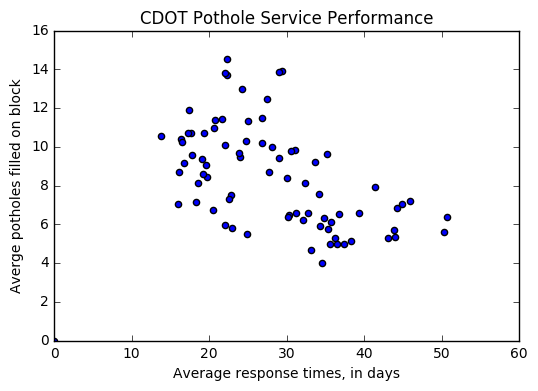

In [6]:
import matplotlib.pyplot as plt

Avg_response_times = []
Avg_potholes_filled_on_block = []
for area in data['Community Area'].unique():
    DF_area = data[data['Community Area']==area]
    Avg_response_times.append(DF_area['TIME TO RESOLUTION'].dt.days.sum()/(len(DF_area)+1))
    Avg_potholes_filled_on_block.append(DF_area['NUMBER OF POTHOLES FILLED ON BLOCK'].sum()/(len(DF_area)+1))



plt.scatter(Avg_response_times,Avg_potholes_filled_on_block)
plt.ylabel('Averge potholes filled on block')
plt.xlabel('Average response times, in days')
plt.title('CDOT Pothole Service Performance')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()


This plot suggests that the number of potholes fixed on an excursion is negatively correlated with response time; as the average potholes filled on a block decreases, then average response time increases.  



### Metrics

Yearly average service Time - The sum of time to resolution divided by the number of requests. This is a global-level metric that measures the efficiency of the service as a whole.

Average potholes fixed - the total number of potholes fixed in a given area divided by the number of requests in that area for a given period of time. This is a measurement of the efficiency of a particular excursion of a crew.  The thought is that it's more efficient to send fewer, more productive excursions than more, less productive excursions.  We'd need further data to confirm this thought, of course.

### CDOT performance on metrics

Let's visualize yearly average service time.

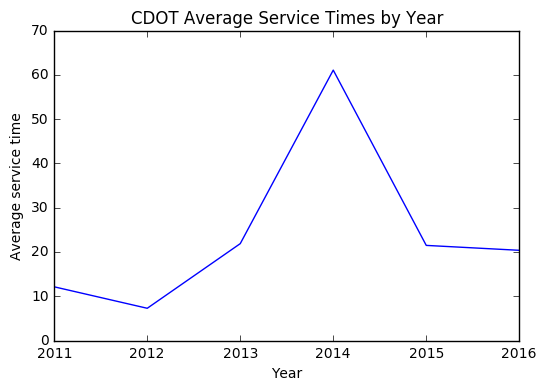

In [15]:
mask_2011 = (data['CREATION DATE'] >= '2011-1-1') & (data['CREATION DATE'] <= '2011-12-31')
mask_2012 = (data['CREATION DATE'] >= '2012-1-1') & (data['CREATION DATE'] <= '2012-12-31')
mask_2013 = (data['CREATION DATE'] >= '2013-1-1') & (data['CREATION DATE'] <= '2013-12-31')
mask_2014 = (data['CREATION DATE'] >= '2014-1-1') & (data['CREATION DATE'] <= '2014-12-31')
mask_2015 = (data['CREATION DATE'] >= '2015-1-1') & (data['CREATION DATE'] <= '2015-12-31')
mask_2016 = (data['CREATION DATE'] >= '2016-1-1') & (data['CREATION DATE'] <= '2016-12-31')

data_2011 = data.loc[mask_2011]
data_2012 = data.loc[mask_2012]
data_2013 = data.loc[mask_2013]
data_2014 = data.loc[mask_2014]
data_2015 = data.loc[mask_2015]
data_2016 = data.loc[mask_2016]
data_2016 = data_2016[data_2016['STATUS'] == 'Completed']


times_2011= []
for i in data_2011['TIME TO RESOLUTION']:
    times_2011.append(i.days)

times_2012= []
for i in data_2012['TIME TO RESOLUTION']:
    times_2012.append(i.days)
    
times_2013= []
for i in data_2013['TIME TO RESOLUTION']:
    times_2013.append(i.days)

times_2014= []
for i in data_2014['TIME TO RESOLUTION']:
    times_2014.append(i.days)

times_2015= []
for i in data_2015['TIME TO RESOLUTION']:
    times_2015.append(i.days)

times_2016= []
for i in data_2016['TIME TO RESOLUTION']:
    times_2016.append(i.days)

Years = [2011, 2012, 2013, 2014, 2015, 2016]
reports_by_year = [sum(times_2011)/len(data_2011),sum(times_2012)/len(data_2012), sum(times_2013)/len(data_2013), sum(times_2014)/len(data_2014), sum(times_2015)/len(data_2015), sum(times_2016)/len(data_2016)]
plt.plot(reports_by_year)
plt.xticks(range(len(reports_by_year)),Years)
plt.xlabel('Year')
plt.ylabel('Average service time')
plt.title('CDOT Average Service Times by Year')
plt.ylim(ymin=0)
plt.show()

As the chart suggests, there was a huge uptick in average response time in 2014, likely correspoding in the nuber of service requests that year.  Since then, CDOT is performing better with respect to this metric, though still nearly double their pre-2014 numbers.  

Now let's visualize Averge potholes fixed.  Let's focus on how this value has changed across years for one of our community areas: Lincoln Park.

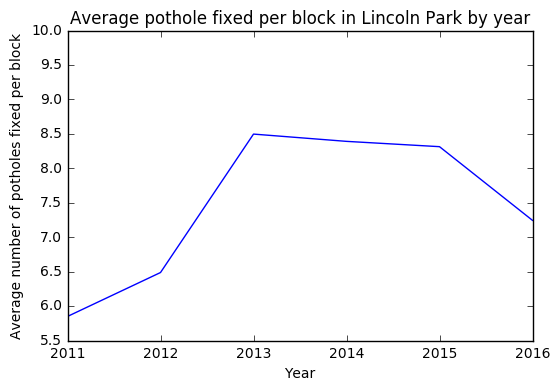

In [8]:
LP_data_2011 = data_2011[data_2011['Community Area'] == 'Lincoln Park']
LP_data_2012 = data_2012[data_2012['Community Area'] == 'Lincoln Park']
LP_data_2013 = data_2013[data_2013['Community Area'] == 'Lincoln Park']
LP_data_2014 = data_2014[data_2014['Community Area'] == 'Lincoln Park']
LP_data_2015 = data_2015[data_2015['Community Area'] == 'Lincoln Park']
LP_data_2016 = data_2016[data_2016['Community Area'] == 'Lincoln Park']

LP_avg_potholes_fixed_yearly = [LP_data_2011['NUMBER OF POTHOLES FILLED ON BLOCK'].sum()/len(LP_data_2011[LP_data_2011['STATUS']=='Completed'])
,LP_data_2012['NUMBER OF POTHOLES FILLED ON BLOCK'].sum()/len(LP_data_2012[LP_data_2012['STATUS']=='Completed'])
,LP_data_2013['NUMBER OF POTHOLES FILLED ON BLOCK'].sum()/len(LP_data_2013[LP_data_2013['STATUS']=='Completed'])
,LP_data_2014['NUMBER OF POTHOLES FILLED ON BLOCK'].sum()/len(LP_data_2014[LP_data_2014['STATUS']=='Completed'])
,LP_data_2015['NUMBER OF POTHOLES FILLED ON BLOCK'].sum()/len(LP_data_2015[LP_data_2015['STATUS']=='Completed'])
,LP_data_2016['NUMBER OF POTHOLES FILLED ON BLOCK'].sum()/len(LP_data_2016[LP_data_2016['STATUS']=='Completed'])
]

plt.plot(LP_avg_potholes_fixed_yearly)
plt.xticks(range(len(LP_avg_potholes_fixed_yearly)),Years)
plt.ylim(ymax=10)
plt.xlabel('Year')
plt.ylabel('Average number of potholes fixed per block')
plt.title('Average pothole fixed per block in Lincoln Park by year')
plt.show()

As we can see, CDOTs rating for this metric is generally up, but on a bit of a downward trend moving from 2015 to 2016.

### Recommendations 

Earlier we saw that increasing the number of potholes filled per excursion is correlated with reducing the service time.  Right now, the mechanism for maximizing efficiency is address-based: the original request acts as an "anchor", and then any pothole within 4 addresses of the anchor on either side will also be filled during that excursion.  It may be, however, that a geographically close pothole that falls outside of the 8-address window is not repaired in the excursion.  Leveraging the lat/lon data available in this data set to define nearby potholes would potentially increase the average pothole filled per excursion score and therefore reduce the average response time.

# Data Visualization

This visualizes the distribution and efficiencies of excursions to Lincoln Park in 2016.  The x and y axes represent latitude and longitude of the pothole being addressed.  The size of the dot represents how many potholes were filled on that excursion; the larger the dot, the greater the number of potholes filled, and thus a more efficient excursion.  You can see how the graphic takes the shape of Lincoln Park pretty nicely, suggesting that potholes are uniformly distributed through the area.

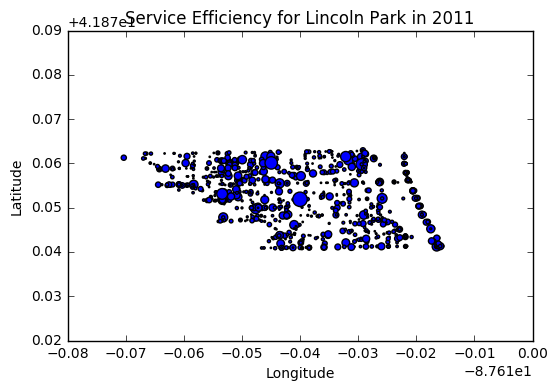

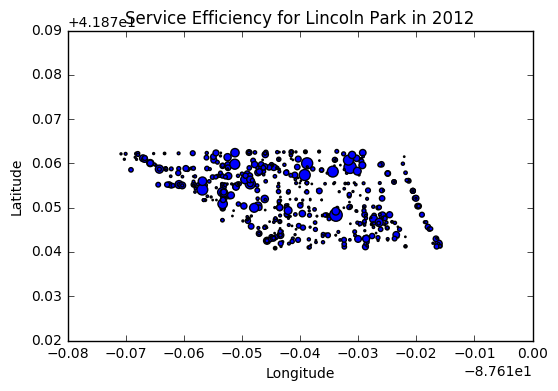

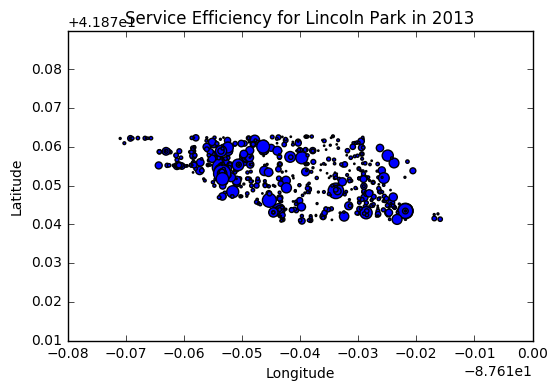

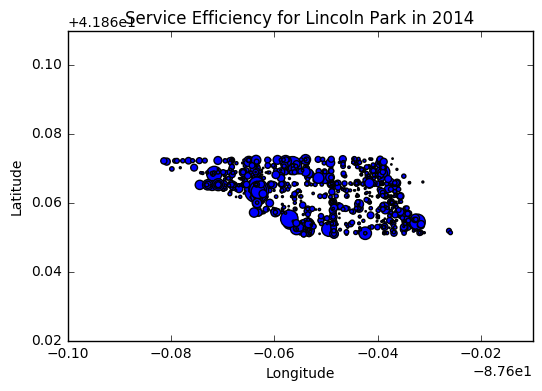

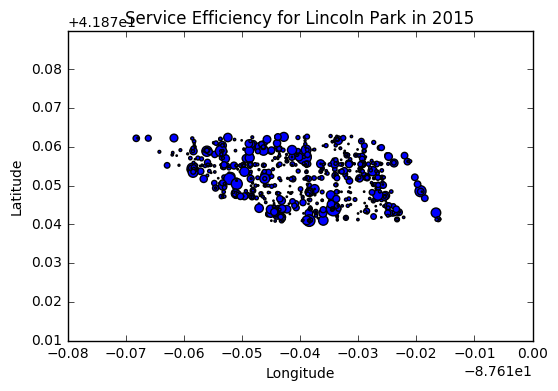

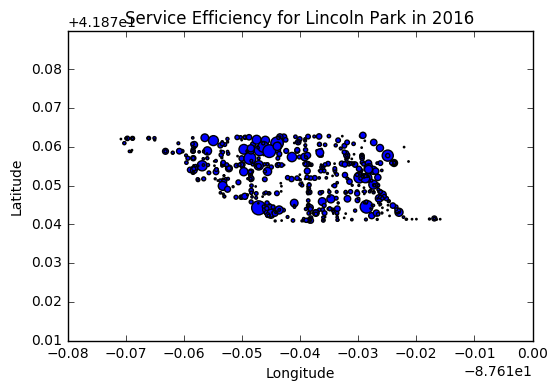

In [16]:
LP_data = [LP_data_2011,LP_data_2012,LP_data_2013,LP_data_2014,LP_data_2015,LP_data_2016]

plt.scatter(LP_data_2011['LONGITUDE'],LP_data_2011['LATITUDE'], s=LP_data_2011['NUMBER OF POTHOLES FILLED ON BLOCK'])
plt.title('2011')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Service Efficiency for Lincoln Park in 2011')
plt.show()

plt.scatter(LP_data_2012['LONGITUDE'],LP_data_2012['LATITUDE'], s=LP_data_2012['NUMBER OF POTHOLES FILLED ON BLOCK'])
plt.title('2012')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Service Efficiency for Lincoln Park in 2012')
plt.show()

plt.scatter(LP_data_2013['LONGITUDE'],LP_data_2013['LATITUDE'], s=LP_data_2013['NUMBER OF POTHOLES FILLED ON BLOCK'])
plt.title('2013')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Service Efficiency for Lincoln Park in 2013')
plt.show()

plt.scatter(LP_data_2014['LONGITUDE'],LP_data_2014['LATITUDE'], s=LP_data_2014['NUMBER OF POTHOLES FILLED ON BLOCK'])
plt.title('2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Service Efficiency for Lincoln Park in 2014')
plt.show()

plt.scatter(LP_data_2015['LONGITUDE'],LP_data_2015['LATITUDE'], s=LP_data_2015['NUMBER OF POTHOLES FILLED ON BLOCK'])
plt.title('2015')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Service Efficiency for Lincoln Park in 2015')
plt.show()

plt.scatter(LP_data_2016['LONGITUDE'],LP_data_2016['LATITUDE'], s=LP_data_2016['NUMBER OF POTHOLES FILLED ON BLOCK'])
plt.title('2016')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Service Efficiency for Lincoln Park in 2016')
plt.show()

The visualization shows the efficiency of service excursions in Lincoln Park over time.  A more efficient year would have fewer, larger dots representing fewer excursions and higher average number of potholes filled on each outing.  The visualization suggests that 2012 had the fewest excursions, since it has the most white space but that 2013 and 2016 are a better mix of white space and larger dots, and so more efficient years.  We also see the most density in 2014, which our earlier visualization suggested had a huge spike in number of total requests to the city.  The graphic here shows that Lincoln Park was caught up in that trend as well.